In [1]:
# want to see the images inline
%matplotlib inline

# general 
import os
# scientific 
import numpy as np
import matplotlib.pyplot as plt
# from sklearn import linear_model, datasets
from scipy.stats import norm, gamma
from scipy.optimize import curve_fit
from scipy import special

import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# these are the parameters that should be passed to the script 
FOLDER = '/Volumes/MILKYKLIM4G/2019-02-19-11-02-35-rs-batch/processing/'
IMAGENAME = 'C1-SEA-12_227'
CSVPATH = FOLDER + "csv/" + IMAGENAME + '.csv'

CENTERPATH = FOLDER  + "centers/" + "all-centers.csv" 

In [3]:
# some const params for all graphs
num_bins = 100 
# graph [xmin, xmax]
xmin = -0.2
xmax = 1.2

binwidth = (xmax - xmin)/(num_bins - 1)
bins = np.arange(xmin, xmax + binwidth, binwidth)
print ('bins: ', bins.shape)

bins:  (100,)


In [4]:
# how good is fitter-meter?
def fitter_meter(y, y_hat):
    return [mean_absolute_error(y,y_hat), np.sqrt(mean_squared_error(y,y_hat))]

In [5]:
# function for loading one data-set
def load_data(file_path, skiprows_=1):
    data = np.loadtxt(file_path, delimiter = '\t', skiprows=skiprows_)
    # print(data.shape) 
    # handles some weird cases, e.g. when there is no data in the file
    if (len(data.shape) < 2):
        data = data[None, :]
    if (data.shape[1] == 0):
        I = np.array([0])
    else:
        I = data[:, -1]
    return I

In [6]:
def create_title(path, name_id=-1):
    # get the name of the initial image
    image_name = path.split("/")[name_id] 
    # print(path.split("/"))
    # create the full title 
    title = image_name[:-4] # drop .csv
    return title

In [7]:
def get_info_text(total, peak, e1, e2):
    return f'Total: {total}\nPeak: {peak:.2f}\nL1: {e1:.2f}\nL2: {e2:.2f}'

In [8]:
# read the db and parse images that we want to process
df = pd.read_csv(FOLDER + "smFISH-database/SEA-12-Table 1.csv", sep=',', na_values=[''])
# df.head()

In [9]:
column = IMAGENAME[:2] + "_type"
row = df[ df['new filename'].values == IMAGENAME[3:]].index[0]

label = df[column].iloc[row]

print(column, row)
print(label)

C1_type 89
MDH-1


In [10]:
# ['DPY-23_EX', 'WDR-5.2', 'MDH-1']
# set color parameter 
color = '#BA5536'
if label == 'MDH-1':
    color = "#693D3D" 
color_dist = '#66A5AD'

In [11]:
center_set = {}

error: L1, L2 [11.414536666255827, 23.641059800824536]
peak center: 0.29494949494949524


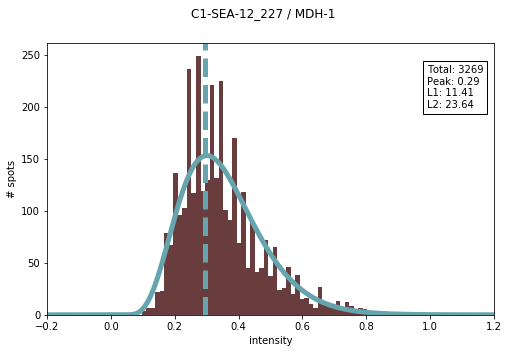

In [12]:
# check that csv with detections exist 
if(not os.path.exists(CSVPATH)):
    print(".csv doesn\'t exist{CSVPATH}")
else:    
    # load the data and scale it accordingly
    I = load_data(CSVPATH, skiprows_=0)
    # calculate the params for gauss fit
    binned_values, real_bins = np.histogram(I, bins)
    use_median = np.median(I)
    fit_alpha, fit_loc, fit_beta = gamma.fit(I, loc=use_median/2, scale=1/np.max(binned_values))
    # normalization factor
    factor = np.sum(binned_values*np.diff(real_bins))

    # create the canvas
    fig = plt.figure(figsize=(8,5))
    title = create_title(CSVPATH, name_id=-1) # -1 last word
    fig.suptitle(title + " / " + label) 
    plt.hist(I, bins=bins, color=color, label=label, density=False)

    x = np.linspace(xmin, xmax, 1000)
    y = gamma.pdf(x, fit_alpha, fit_loc, fit_beta)*factor
    plt.plot(x,y, linewidth=5, color=color_dist)
    yhat = gamma.pdf(real_bins, fit_alpha, fit_loc, fit_beta)*factor

    # vertical line for center
    plt.axvline(x=real_bins[np.argmax(yhat)], linestyle="--", linewidth=5, color=color_dist)

    if (not np.any(np.isnan(yhat))):
        error = fitter_meter(binned_values, yhat[:-1])

        print("error: L1, L2", error)
        print("peak center:", real_bins[np.argmax(yhat)])

        # reasonable adjustments to make the data look nicer
        info_text = get_info_text(I.shape[0], real_bins[np.argmax(yhat)], error[0], error[1])
        
        x_limits = [xmin, xmax]
        ymax = np.max(np.histogram(I, bins)[0])
        y_limits = [0, ymax]
 
        plt.xlabel('intensity')
        plt.ylabel('# spots')
        plt.text(x_limits[1] - (x_limits[1] - x_limits[0])*0.15, y_limits[1]*0.8, info_text, color='black', bbox=dict(facecolor='white', alpha=1))
        plt.xlim([xmin, xmax])

        # save the peak values for further 
        center_set[title] = real_bins[np.argmax(yhat)]
    
        HISTOGRAMFOLDER = FOLDER + "histograms/" + label + "/"
        HISTOGRAMFILE = HISTOGRAMFOLDER + IMAGENAME + ".pdf"
        if not os.path.exists(HISTOGRAMFOLDER):
            os.makedirs(HISTOGRAMFOLDER)
        plt.savefig(HISTOGRAMFILE) 
        plt.show()
        
df_center = pd.DataFrame(list(center_set.items()), columns=['filename', 'center'])
if (os.path.exists(CENTERPATH)):
    df_center.to_csv(CENTERPATH, index=False, header=False, encoding='utf-8', mode = 'a')
else:
    df_center.to_csv(CENTERPATH, index=False, header=True, encoding='utf-8', mode = 'w' )
    print (df_center)

### ?plt.hist